# Accessing PubChem through PUG-REST: Part III

```{dropdown} About this interactive ![icons](../images/rocket.png) recipe
- Author: [Sunghwan Kim](https://orcid.org/0000-0001-9828-2074)
- Reviewer:
- Topics:
- Format: Interactive Jupyter Notebook (Python)
- Scenarios:
- Skills:
- Learning outcomes:
- Citation: 'Accessing PubChem through PUG-REST - Part III', The IUPAC FAIR Chemistry Cookbook, https://iupac.github.io/WFChemCookbook/samples/pubchem-pug-rest3.html
- Reuse: This notebook is made available under a [CC-BY-4.0](https://creativecommons.org/licenses/by/4.0/) license.
```

In [1]:
import requests
import time
import io
import csv
from IPython.display import Image, display

## 1. Using a SMILES or InChI string as an input query

In [2]:
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
print(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/" + smiles + "/cids/txt").text.strip())

2244


Some SMILES strings contain characters not compatible with the PUG-REST request URL syntax.  For example, isomeric SMILES uses the "/" character (forward slash) to represent the E/Z or cis/trans stereochemistry of a molecule.  However, because the "/" character is also used in the request URL to separate the segments of the URL path, the use of such SMILES strings as an input structure will result an error.

In [3]:
smiles = "CC(C)C1=NC(=NC(=C1/C=C/[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)N(C)S(=O)(=O)C"
print(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/" + smiles + "/cids/txt").text.strip())

Status: 400
Code: PUGREST.BadRequest
Message: Unable to standardize the given structure - perhaps some special characters need to be escaped or data packed in a MIME form?
Detail: error: 
Detail: status: 400
Detail: output: Caught ncbi::CException: Standardization failed
Detail: Output Log:
Detail: Record 1: Warning: Cactvs Ensemble cannot be created from input string
Detail: Record 1: Error: Unable to convert input into a compound object
Detail: 
Detail:


To circumvent this issue, the SMILES input should be provided in one of the following two ways:
1. as a URL parameter
2. in the HTTP header (using the HTTP POST method).

In [4]:
smiles = "CC(C)C1=NC(=NC(=C1/C=C/[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)N(C)S(=O)(=O)C"

# As a URL parameter
print(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/cids/txt" + "?smiles=" + smiles).text.strip())

# In the HTTP header (using HTTP Post)
print(requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/cids/txt", data={'smiles':smiles}).text.strip())

446157
446157


InChI encodes the chemical structure information into multiple layers and sublayers, separated by the "/" character.  For this reason, InChI strings should also be provided as a URL parameter or in the HTTP header (using HTTP host).

In [5]:
inchi = "InChI=1S/C9H8O4/c1-6(10)13-8-5-3-2-4-7(8)9(11)12/h2-5H,1H3,(H,11,12)"

# With the request URL : WILL NOT WORK
#print(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchi/" + inchi + "/cids/txt").text.strip())

# As a URL parameter
print(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchi/cids/txt" + "?inchi=" + inchi).text.strip())

# In the HTTP header (using HTTP Post)
print(requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/inchi/cids/txt", data={'inchi':inchi}).text.strip())

2244
2244


## 2. Performing identity search

In [6]:
smiles = "CC(C)/C=C/I"

In [7]:
# Compounds with the same stereochemistry and isotopism (default)
print(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastidentity/cid/14571425/cids/txt").text.strip())
print(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastidentity/cid/14571425/cids/txt?identity_type=same_stereo_isotope").text.strip())

14571425
14571425


['14571425', '14571426', '71380237']


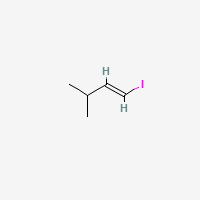

CID 14571425 : CC(C)/C=C/I



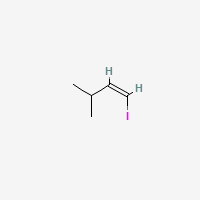

CID 14571426 : CC(C)/C=C\I



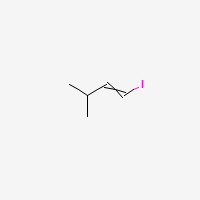

CID 71380237 : CC(C)C=CI



In [8]:
# Compounds with the same isotopism (stereochemistry can be different)
cids1 = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastidentity/smiles/cids/txt?identity_type=same_isotope", data={'smiles':smiles}).text.strip().split()
print(cids1)

for mycid in cids1:
    display(Image(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/" + mycid + "/record/PNG?image_size=200x200").content))
    print("CID " + mycid, ":", requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/" + mycid + "/property/IsomericSMILES/TXT").text)
    time.sleep(0.2)

['14571425', '118122558']


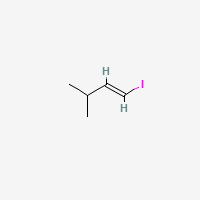

CID 14571425 : CC(C)/C=C/I



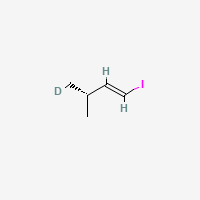

CID 118122558 : [2H]C[C@@H](C)/C=C/I



In [9]:
# Compounds with the same stereochemistry (isotopism can be different)
cids2 = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastidentity/smiles/cids/txt?identity_type=same_stereo", data={'smiles':smiles}).text.strip().split()
print(cids2)

for mycid in cids2:
    display(Image(requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/" + mycid + "/record/PNG?image_size=200x200").content))
    print("CID " + mycid, ":", requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/" + mycid + "/property/IsomericSMILES/TXT").text)
    time.sleep(0.2)

In [10]:
# Compounds with the same connectivity (stereochemistry and isotopism can be different)
cids3 = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastidentity/smiles/cids/txt?identity_type=same_connectivity", data={'smiles':smiles}).text.strip().split()
print(cids3)    # All compounds in cids1 and cids2 are returned.

['14571425', '14571426', '71380237', '118122558', '123616558']


## 3. Performing 2-D and 3-D similarity search

In [11]:
smiles = "CC1([C@@H]2[C@H]1[C@H](N(C2)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C"
cids = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsimilarity_2d/smiles/cids/txt", data={'smiles':smiles}).text.strip().split()
print(len(cids))
print(cids)

100
['155903259', '163421961', '164850071', '164785132', '164766041', '164766036', '164701821', '164701819', '164701818', '164701817', '164701816', '164701815', '164701813', '164701812', '164701807', '164701805', '164701800', '164701794', '164701789', '164701777', '164701776', '164701775', '164701773', '164701772', '164701766', '164701760', '164701758', '164701757', '164701749', '164701748', '164701743', '164701742', '164701741', '164701738', '164701736', '164701733', '164159966', '164158215', '163362031', '163362029', '163362026', '163362016', '163362014', '163362009', '163362008', '163362005', '163362001', '163361998', '163361997', '163361849', '163283407', '163283390', '163283387', '163283371', '163283370', '163283343', '163283330', '163283322', '163283284', '163283243', '163283239', '163283238', '163283236', '162479130', '162478807', '162396459', '162396458', '162396453', '162396452', '162396372', '164850290', '164850073', '164701802', '164701798', '164040179', '163941851', '163362

You can adjust the similarity threshold using the optional parameter "**Threshold**".  T The following request performs a 2-D similarity search with a tighter similarity threshold (95)

In [12]:
smiles = "CC1([C@@H]2[C@H]1[C@H](N(C2)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C"
cids = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsimilarity_2d/smiles/cids/txt?Threshold=99", data={'smiles':smiles}).text.strip().split()
print(len(cids))
print(cids)

14
['155903259', '164701818', '164701813', '164701812', '164701760', '164701758', '163362031', '163362005', '163362001', '163361849', '162396459', '164040179', '163341926', '163285815']


Note that the use of the higher threshold (99) than the default (90) results in fewer structures.

It is also possible to get line notations and molecular properties for the compounds returned from chemical structure search.

In [13]:
data = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsimilarity_2d/smiles/property/HeavyAtomCount,MolecularFormula,IsomericSMILES/csv?Threshold=99", data={'smiles':smiles}).text.strip()
print(data)

"CID","HeavyAtomCount","MolecularFormula","IsomericSMILES"
155903259,35,"C23H32F3N5O4","CC1([C@@H]2[C@H]1[C@H](N(C2)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C"
164701818,35,"C23H32F3N5O4","CC1(C2C1C(N(C2)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@H](C[C@@H]3CCNC3=O)C#N)C"
164701813,35,"C23H32F3N5O4","CC(C)C[C@@H](C(=O)N1CC2C(C1C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C2(C)C)NC(=O)C(F)(F)F"
164701812,35,"C23H32F3N5O4","CC1(C2C1C(N(C2)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C"
164701760,36,"C24H34F3N5O4","CC1(C2C1C(N(C2)C(=O)[C@H](CC(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C"
164701758,35,"C23H32F3N5O4","CC(C)[C@@H](C(=O)N1CC2C(C1C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C2(C)C)NC(=O)CC(F)(F)F"
163362031,36,"C24H34F3N5O4","CC1([C@@H]2[C@H]1[C@H](N(C2)C(=O)[C@H](CC(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C"
163362005,35,"C23H32F3N5O4","CC(C)[C@@H](C(=O)N1C[C@H]2[C@@H]([C@H]1C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C2(C)C)NC(=O)C

In [14]:
smiles = "CC1([C@@H]2[C@H]1[C@H](N(C2)C(=O)[C@H](C(C)(C)C)NC(=O)C(F)(F)F)C(=O)N[C@@H](C[C@@H]3CCNC3=O)C#N)C"
cids = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsimilarity_3d/smiles/cids/txt", data={'smiles':smiles}).text.strip().split()
print(len(cids))
print(cids)

3
['155903259', '163321803', '44227150']


Currently, the similarity threshold used for 3-D similarity search is not adjustable, contrary to 2-D similarity search.

## 5. Performing substructure/superstructure search

In [15]:
smiles = "C2CN=C(C1=C(C=CC=C1)N2)C3=CC=CC=C3"
cids = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsubstructure/smiles/cids/txt", data={'smiles':smiles}).text.strip().split()
print(len(cids))

38488


In [16]:
smiles = "C2CN=C(C1=C(C=CC=C1)N2)C3=CC=CC=C3"
cids = requests.post("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastsuperstructure/smiles/cids/txt", data={'smiles':smiles}).text.strip().split()
print(len(cids))

6746


## 7. Molecular Formula search

In [17]:
formula = "C6H12O6"
cids = requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastformula/" + formula +"/cids/txt").text.strip().split()
print(len(cids))

1507


You can download the structural information for the compounds returned from the molecular formula search.

In [18]:
data = requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastformula/" + formula +"/property/MolecularFormula,IsomericSMILES/CSV").text.strip()

cid_props = {}
reader = csv.reader(io.StringIO(data))
print(next(reader))  # Print the first line (column header)

for row in reader:
    key = row[0]
    cid_props[key] = row[1:]

count = 0
for item in cid_props:
    
    count += 1
    print(item, "\t", cid_props[item][0], "\t", cid_props[item][1])
    if count == 10 :  # For simplicity, print only the first 10 items.
        break

['CID', 'MolecularFormula', 'IsomericSMILES']
2723872 	 C6H12O6 	 C1[C@H]([C@H]([C@@H](C(O1)(CO)O)O)O)O
107526 	 C6H12O6 	 C([C@H]([C@H]([C@@H]([C@H](C=O)O)O)O)O)O
24749 	 C6H12O6 	 C(C(C(C(C(C=O)O)O)O)O)O
24310 	 C6H12O6 	 C1[C@H]([C@H]([C@@H]([C@](O1)(CO)O)O)O)O
892 	 C6H12O6 	 C1(C(C(C(C(C1O)O)O)O)O)O
64689 	 C6H12O6 	 C([C@@H]1[C@H]([C@@H]([C@H]([C@@H](O1)O)O)O)O)O
5984 	 C6H12O6 	 C([C@H]([C@H]([C@@H](C(=O)CO)O)O)O)O
439709 	 C6H12O6 	 C([C@@H]1[C@H]([C@@H]([C@](O1)(CO)O)O)O)O
439312 	 C6H12O6 	 C1[C@H]([C@@H]([C@@H](C(O1)(CO)O)O)O)O
79025 	 C6H12O6 	 C([C@@H]1[C@H]([C@@H]([C@H]([C@H](O1)O)O)O)O)O


In [19]:
cids = requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastformula/" + formula +"/cids/txt?AllowOtherElements=True").text.strip().split()
print(len(cids))

3235


In [ ]:
data = requests.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/fastformula/" + formula +"/property/MolecularFormula,IsomericSMILES/CSV?AllowOtherElements=True").text.strip()

cid_props = {}
reader = csv.reader(io.StringIO(data))
print(next(reader))  # Print the first line (column header)

for row in reader:
    key = row[0]
    cid_props[key] = row[1:]

count = 0
for item in cid_props:
    
    count += 1
    print(item, "\t", cid_props[item][0], "\t", cid_props[item][1])
    if count == 10 :  # For simplicity, print only the first 10 items.
        break